In [103]:
# Standard Python Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import cv2
import os
import shutil
import pywt
import joblib
import json

# Machine Learning Library Import
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix

In [3]:
img = cv2.imread('../images_dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg')
img.shape

(1024, 683, 3)

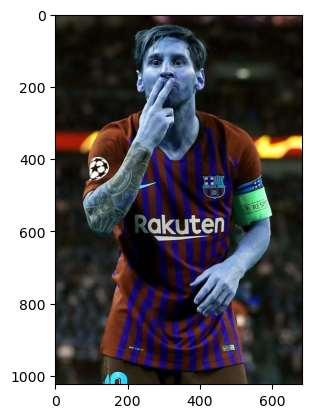

In [4]:
plt.imshow(img)

In [9]:
grey = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
grey.shape

(1024, 683)

In [12]:
# Using haar cascade features to identify the features
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(grey,1.3,5)

x,y,w,h = faces[0]

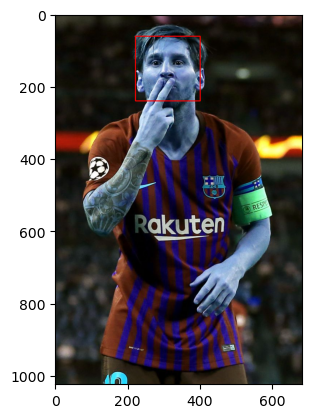

In [14]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

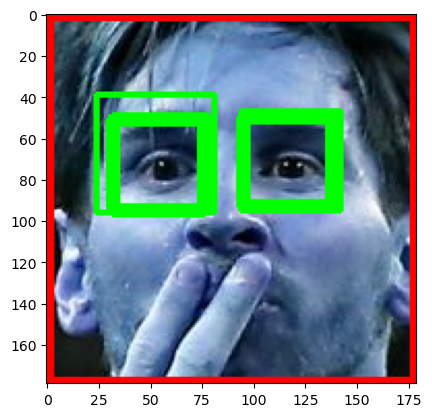

In [19]:
# cropping the image
cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0))
    roi_grey = grey[y:y+h,x:x+w]
    roi_color = face_img[y:y+h,x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_grey)
    for(ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.figure()
plt.imshow(roi_color,cmap="gray")
plt.show()

In [21]:
# Function to get the cropped image using cv2 and haar cascade
def get_cropped_image(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = img[y:y+h,x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

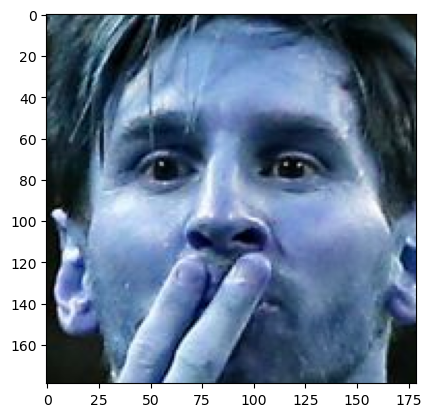

In [22]:
cropped_image = get_cropped_image('../images_dataset/lionel_messi/02453493f852c0efe8ff951dea5845c4.jpg')
plt.imshow(cropped_image)

In [23]:
cropped_image_2 = get_cropped_image('../images_dataset/maria_sharapova/2900.jpg')
cropped_image_2

In [25]:
# Standard file paths
path_to_data = '../images_dataset/'
path_to_cropped_data = '../images_dataset/cropped/'

In [32]:
# Storing the file paths into the list
img_dir = []
for k in os.scandir(path_to_data):
    if k.is_dir():
        img_dir.append(k.path)

print(img_dir)

['../images_dataset/lionel_messi', '../images_dataset/maria_sharapova', '../images_dataset/roger_federer', '../images_dataset/serena_williams', '../images_dataset/virat_kohli', '../images_dataset/cropped']


In [29]:
# Creating the cropped folder
if os.path.exists(path_to_cropped_data):
    shutil.rmtree(path_to_cropped_data)
os.mkdir(path_to_cropped_data)

In [31]:
# Function to generate the cropped image
cropped_image_dirs = []
celebrity_file_names_dict = {}

for image in img_dir:
    count = 1
    celebrity_name = image.split('/')[-1]
    print(celebrity_name)
    celebrity_file_names_dict[celebrity_name] = []
    for k in os.scandir(image):
        roi_color = get_cropped_image(k.path)
        if roi_color is not None:
            cropped_folder = path_to_cropped_data+celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped image in folderr",cropped_folder)
            cropped_file_name = celebrity_name + str(count)+".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name

            cv2.imwrite(cropped_file_path,roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

lionel_messi
Generating cropped image in folderr ../images_dataset/cropped/lionel_messi
maria_sharapova
Generating cropped image in folderr ../images_dataset/cropped/maria_sharapova
roger_federer
Generating cropped image in folderr ../images_dataset/cropped/roger_federer
serena_williams
Generating cropped image in folderr ../images_dataset/cropped/serena_williams
virat_kohli
Generating cropped image in folderr ../images_dataset/cropped/virat_kohli


In [36]:
# Pywavelet function to extract the features from the image
def w2d(img,mode="haar",level=1):
    imArray = img
    imArray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imArray = np.float32(imArray)
    imArray /= 256;
    coeffs = pywt.wavedec2(imArray,mode,level)
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0;
    imArray_H = pywt.waverec2(coeffs_H,mode);
    imArray_H *= 255;
    imArray_H = np.uint8(imArray_H)
    return imArray_H

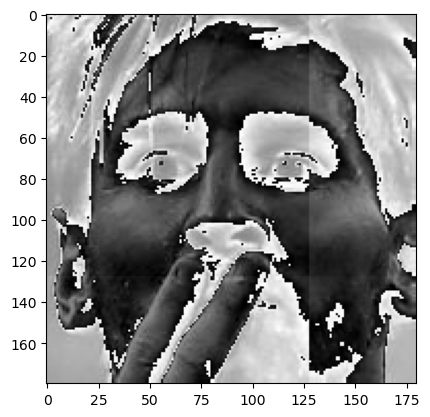

In [37]:
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har,cmap="gray")


In [39]:
# Assigning the numbers to the names
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count += 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [83]:
# creating the vertical stack of the input data to feed it to the model
x = []
y = []
for celebrity_name , training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scaled_raw_image = cv2.resize(img,(32,32))
        img_har = w2d(scaled_raw_image,"db1",5)
        scaled_img_haar = cv2.resize(img_har,(32,32))
        combined_img = np.vstack((scaled_raw_image.reshape(32*32*3,1),scaled_img_haar.reshape(32*32,1)))
        x.append(combined_img)
        y.append(class_dict[celebrity_name])

[ WARN:0@10001.170] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/lionel_messi/lionel_messi36.png'): can't open/read file: check file path/integrity
[ WARN:0@10001.170] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/lionel_messi/lionel_messi37.png'): can't open/read file: check file path/integrity
[ WARN:0@10001.206] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/maria_sharapova/maria_sharapova3.png'): can't open/read file: check file path/integrity
[ WARN:0@10001.325] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/maria_sharapova/maria_sharapova9.png'): can't open/read file: check file path/integrity
[ WARN:0@10001.337] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/maria_sharapova/maria_sharapova12.png'): can't open/read file: check file path/integrity
[ WARN:0@10001.589] global loadsave.cpp:244 findDecoder imread_('../images_dataset/cropped/maria_sharapova/maria_s

In [86]:
x = np.array(x).reshape(len(x),4096).astype(float)
x.shape


(169, 4096)

In [88]:
#building model

x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC(kernel='rbf',C=10))
])

pipe.fit(x_train,y_train)
pipe.score(x_test,y_test)

0.8372093023255814

In [91]:
y_preds = pipe.predict(x_test)
report = classification_report(y_test,y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       1.00      0.80      0.89        10
           2       0.80      0.80      0.80         5
           3       0.73      0.89      0.80         9
           4       0.85      0.92      0.88        12

    accuracy                           0.84        43
   macro avg       0.84      0.82      0.83        43
weighted avg       0.85      0.84      0.84        43



In [96]:
model_params = {
    'svm': {
        'model': SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [99]:
scores = []
best_estimators = {}

for algo,mp in model_params.items():
    pipe = make_pipeline(StandardScaler(),mp['model'])
    clf = GridSearchCV(pipe,mp['params'],cv=5,return_train_score=False)
    clf.fit(x_train,y_train)
    scores.append({
        'model' : algo,
        'best_score' :clf.best_score_,
        'best_estimator' : clf.best_params_
    })

    best_estimators[algo] = clf.best_estimator_

df = pd.DataFrame(scores,columns=['model','best_score','best_estimator'])
df

,model,best_score,best_estimator
0,svm,0.832923,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.673231,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.873231,{'logisticregression__C': 1}


In [102]:
best_clf = best_estimators['svm']

In [104]:
cm = confusion_matrix(y_test,best_clf.predict(x_test))

Text(95.72222222222221, 0.5, 'True')

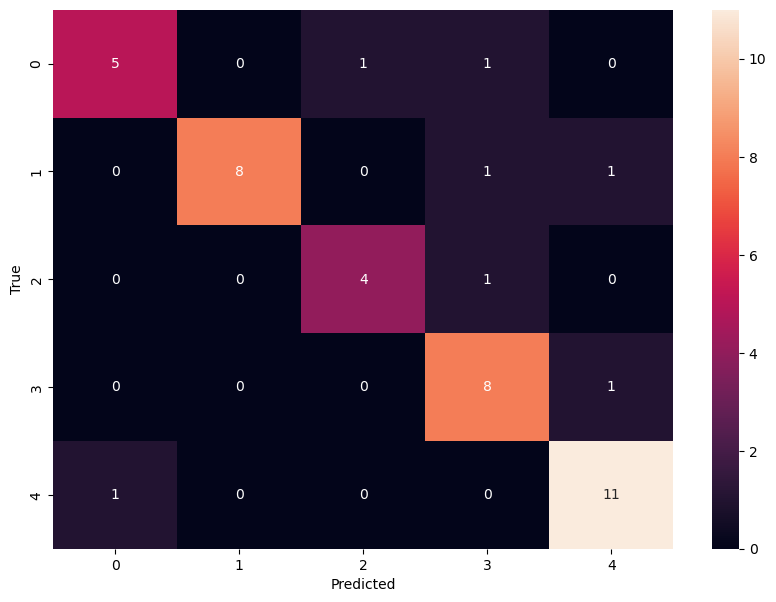

In [105]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [106]:
joblib.dump(best_clf,'model.pkl')

['model.pkl']

In [108]:
with open("class_dictionary.json","w") as f:
    f.write(json.dumps(class_dict))